
Epoch 1/10


Testing: 100%|██████████| 407/407 [00:08<00:00, 46.78it/s]


Train Loss: 2.2583 | Train Accuracy: 17.82%
Test  Loss: 2.2269 | Test  Accuracy: 19.59%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 19.59%

Epoch 2/10


Testing: 100%|██████████| 407/407 [00:07<00:00, 57.18it/s]


Train Loss: 1.8170 | Train Accuracy: 36.37%
Test  Loss: 1.1882 | Test  Accuracy: 61.88%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 61.88%

Epoch 3/10


Testing: 100%|██████████| 407/407 [00:07<00:00, 51.40it/s]


Train Loss: 1.0017 | Train Accuracy: 68.14%
Test  Loss: 0.8728 | Test  Accuracy: 72.67%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 72.67%

Epoch 4/10


Testing: 100%|██████████| 407/407 [00:08<00:00, 49.62it/s]


Train Loss: 0.7982 | Train Accuracy: 75.08%
Test  Loss: 0.7569 | Test  Accuracy: 76.50%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 76.50%

Epoch 5/10


Testing: 100%|██████████| 407/407 [00:07<00:00, 52.38it/s]


Train Loss: 0.6978 | Train Accuracy: 78.12%
Test  Loss: 0.6817 | Test  Accuracy: 78.68%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 78.68%

Epoch 6/10


Testing: 100%|██████████| 407/407 [00:07<00:00, 54.27it/s]


Train Loss: 0.6298 | Train Accuracy: 80.31%
Test  Loss: 0.6407 | Test  Accuracy: 79.72%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 79.72%

Epoch 7/10


Testing: 100%|██████████| 407/407 [00:08<00:00, 49.95it/s]


Train Loss: 0.5813 | Train Accuracy: 81.85%
Test  Loss: 0.6044 | Test  Accuracy: 81.05%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 81.05%

Epoch 8/10


Testing: 100%|██████████| 407/407 [00:08<00:00, 48.92it/s]


Train Loss: 0.5444 | Train Accuracy: 83.01%
Test  Loss: 0.5911 | Test  Accuracy: 81.78%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 81.78%

Epoch 9/10


Testing: 100%|██████████| 407/407 [00:07<00:00, 53.70it/s]


Train Loss: 0.5139 | Train Accuracy: 83.97%
Test  Loss: 0.5613 | Test  Accuracy: 82.55%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 82.55%

Epoch 10/10


Testing: 100%|██████████| 407/407 [00:07<00:00, 51.67it/s]


Train Loss: 0.4865 | Train Accuracy: 84.80%
Test  Loss: 0.5484 | Test  Accuracy: 83.14%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 83.14%


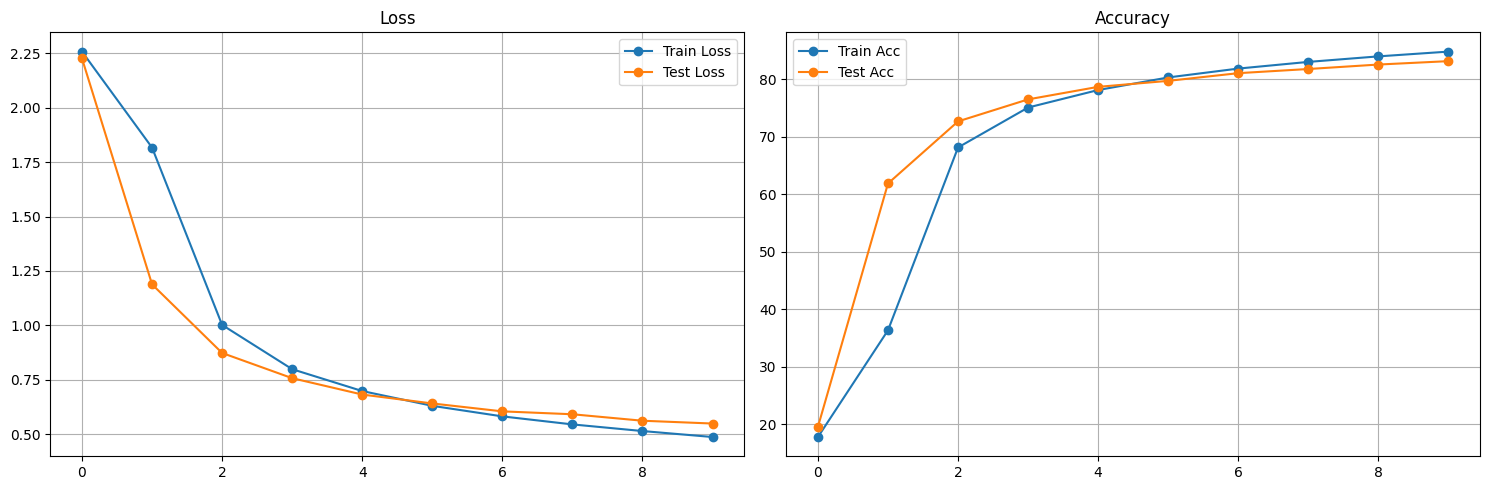


✅ Best Test Accuracy: 83.14%
Done.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Configuration des hyperparamètres optimisés
img_size = 32
n_channels = 3
patch_size = 8
d_model = 128
num_heads = 4
num_layers = 6
num_classes = 10   # Modifié pour SVHN
ff_dim = 512
dropout = 0.1

# Hyperparamètres d'optimisation
lr = 1e-4
weight_decay = 1e-4
batch_size = 64
num_epochs = 10

# Scheduler
patience = 5
factor = 0.5

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.patch_embedding = nn.Conv2d(
            in_channels=n_channels,
            out_channels=d_model,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class ViT(nn.Module):
    def __init__(self, img_size, n_channels, patch_size, d_model, num_heads, num_layers, num_classes, ff_dim, dropout):
        super(ViT, self).__init__()
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        N, C, H, W = x.shape
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.repeat(N, 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embedding
        x = self.transformer_encoder(x)
        x = self.dropout(x)
        x = self.fc(x[:, 0])
        return x

def get_data_loaders(batch_size=batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_data = SVHN(root='./data', split='train', download=True, transform=transform)
    extra_data = SVHN(root='./data', split='extra', download=True, transform=transform)
    test_data = SVHN(root='./data', split='test', download=True, transform=transform)

    full_train_data = ConcatDataset([train_data, extra_data])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def test(model, test_loader, criterion, device):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader), 100 * correct / total

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, test_loader = get_data_loaders()

    model = ViT(img_size, n_channels, patch_size, d_model, num_heads, num_layers, num_classes, ff_dim, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)#, weight_decay=weight_decay)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=patience, factor=factor, verbose=True)

    t_train_loss, t_test_loss = [], []
    t_train_acc, t_test_acc = [], []

    best_test_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        #scheduler.step(test_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%')
        print(f'Test  Loss: {test_loss:.4f} | Test  Accuracy: {test_acc:.2f}%')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.2e}')

        t_train_loss.append(train_loss)
        t_test_loss.append(test_loss)
        t_train_acc.append(train_acc)
        t_test_acc.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_vit_svhn.pth')
            print(f"✅ Nouveau meilleur modèle sauvegardé avec {best_test_acc:.2f}%")

    # Tracé
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(t_train_loss, label='Train Loss', marker='o')
    ax[0].plot(t_test_loss, label='Test Loss', marker='o')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(t_train_acc, label='Train Acc', marker='o')
    ax[1].plot(t_test_acc, label='Test Acc', marker='o')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Best Test Accuracy: {best_test_acc:.2f}%")
    print("Done.")

if __name__ == "__main__":
    main()